<a href="https://colab.research.google.com/github/musicjae/cs231n/blob/master/assignment2/cs231n(2017)_lecture8_intro_to_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
from google.colab import files
uploaded = files.upload() # 파일 업로드 기능 실행

for fn in uploaded.keys(): # 업로드된 파일 정보 출력
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

Saving t3.png to t3.png
User uploaded file "t3.png" with length 251328 bytes


In [3]:
from IPython.display import Image

## Pytorch. 
  
파이토치는 3 가지 점에서 텐서플로우랑 다르다. 파이토치는 넘파이 array 같은 텐서를 갖는다. 이것은 imperative array이고, 딥러닝에 대한 어떤 것도 알지 못하지만, GPU에서 돌아간다. 또한, 데이터와 그래디언트를 저장하는 계산 그래프 안의 노드인 variables이 있다. 마지막으로, 우리는 큰 연결망을 만들기 위한 신경망 레이어인 모듈 대상을 갖는다.  
  
파이토치에서 텐서는 텐서플로우에서 넘파이의 배열과 같은 역할을 한다는 것은 중요하다. 또한, 파이토치 모듈은 tf.slim, tf.laye등과 동치이다.  파이토치는 그 자체로 모듈이라고 불리는 <하이레벨 추상화>에 대해 매우 좋다.  
  
아래 코드를 보면 우리가 numpy를 임포트하지 않은 것에 주목하라. 우리는 오직 파이토치 텐서만을 이용하여 계산을 한다. 

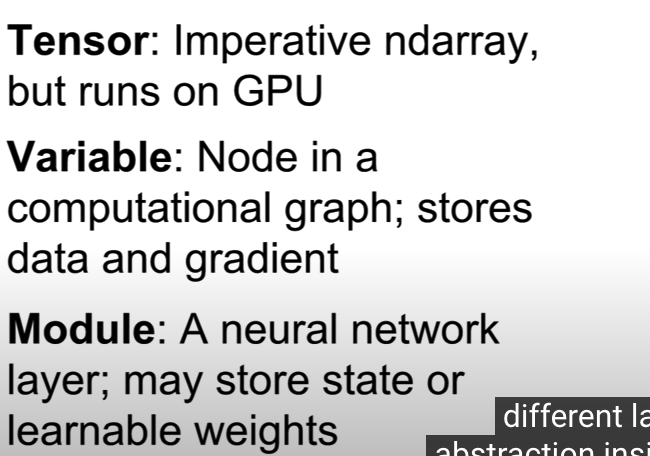

In [5]:
Image('t1.png',width=400)

In [15]:
import torch
dtype = torch.FloatTensor #GPU를 키기 위해 이같이 쓴다.

N, D_in, H, D_out = 64, 1000, 100, 10
x = torch.randn(N, D_in).type(dtype)
y = torch.randn(N, D_out).type(dtype) # 데이터, 가중치에 대한 랜덤 텐서 생성
w1 = torch.randn(D_in, H).type(dtype)
w2 = torch.randn(H, D_out).type(dtype)

# 순전파: 예측, 손실 계산

learning_rate = 1e-6
for t in range(500):

    h=x.mm(w1)
    h_relu = h.clamp(min=0)
    y_pred = h_relu.mm(w2)
    loss = (y_pred - y).pow(2).sum()

# 역전파: 수기로 그래디언트 계산 

    grad_y_pred = 2.0 * (y_pred - y)
    grad_w2 = h_relu.t().mm(grad_y_pred)
    grad_h_relu = grad_y_pred.mm(w2.t())

    grad_h = grad_h_relu.clone()
    grad_h[h<0] = 0
    grad_w1 = x.t().mm(grad_h)

# 가중치 업데이트
    w1 -= learning_rate * grad_w1
    w2 -= learning_rate * grad_w2

파이토치와 텐서와 variable은 동일한 API를 쓴다. 따라서 파이토치 텐서로 돌아가는 모든 코드는 variable로 만들어도 돌아간다. 이것을 사용할 때, 데이터에 대한 그래디언트를 원하지 않으면, false를 사용하고, 가중치에 대한 그래디언트를 원하면, true를 입력한다. 텐서와 API가 같기 때문에 순전파 시에는 완전 비슷하다. 마지막은 넘파이 배열과 거의 비슷하게 끝난다  
  
텐서플로우 경우에는 명시적 그래프를 구성하는데, 파이토치에서는 새로운 그래프를 우리가 순전파를 다룰 때마다 구성한다.

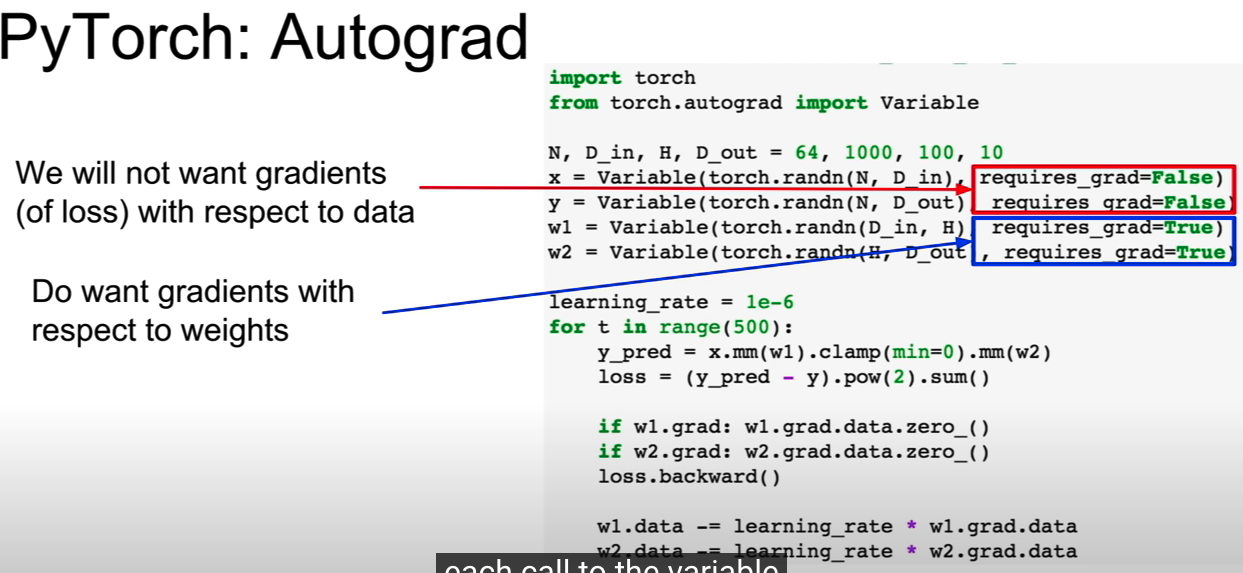

In [8]:
Image('t2.png')

따라서 파이토치는 텐서에 의해 순전파와 역전파를 정의함으로써 우리는 새로운 autograd 함수를 정의할 수 있다. 이것은 결국 모듈 레이어 같은 것처럼 보이게 된다. 

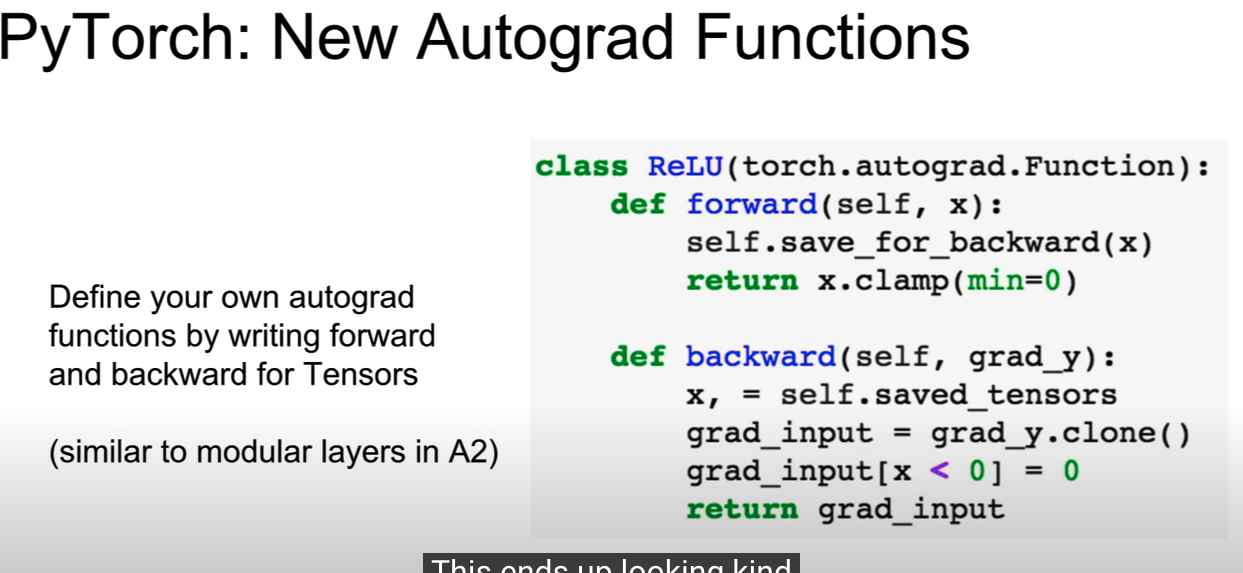

In [11]:
Image('t3.png')

 파이토치에서는 nn 패키지를 통해 고차 wrappers를 다룬다. 우리는 이걸 가지고 일련의 레이어로서의 모델을 정의한다.

In [16]:
import torch
from torch.autograd import Variable
N, D_in, H, D_out = 64, 1000, 100, 10

x = Variable(torch.randn(N, D_in))
y = Variable(torch.randn(N, D_out), requires_grad = False)
# 일련의 레이어로서의 모델 정의
model = torch.nn.Sequential(
    torch.nn.Linear(D_in,H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out))

loss_fn = torch.nn.MSELoss(size_average=False)

learning_rate = 1e-4
# 최적화 제공
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

for t in range(500):
    # 순전파: 모델에 데이터 넣고, 손실 함수에 예측 넣어.
    y_pred = model(x)
    loss = loss_fn(y_pred, y)
    # 모든 그래디언트 계산해줘
    model.zero_grad()
    loss.backward()
    
    optimizer.step() # 그래디언트 계산 이후에, 모든 모수 업데이트
    # 각 모델 패러미터에 대해 그래디언트를 돌린다.
    # 순전파를 하는 모든 시간에서 새로운 계산 그래프를 구성
    for param in model.parameters():

        param.data -= learning_rate * param.grad.data

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


### nn 모듈

In [ ]:
from torch.autograd import Variable

# (1) 단일 모듈로서의 전체 모델 정의하기

class TwoLayerNet(torch.nn.Module):

    def __init__(self, D_in, H, D_out):

        super(TwoLayerNet, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H) #초기화 
        self.linear2 = torch.nn.Linear(H, D_out)

#(2) child 모듈과 autograd 를 사용해서 순전파 정의하기.
# 역전파는 정의할 필요 x. autograd가 해줘.
    def forward(self, x):

        h_relu = self.linear1(x).clamp(min=0)
        y_pred = self.linear2(h_relu)
        return y_pred